In [2]:
from torch import nn
import torch
import torch.nn.functional as F
import torchvision
import timm
from torch.nn.parameter import Parameter
import albumentations as A

from utils import parse_args, prepare_for_result
from torch.utils.data import DataLoader, Dataset
from losses import get_loss, get_class_balanced_weighted
from dataloaders import get_dataloader
from utils import load_matched_state
from configs import Config
from models import get_model
from dataloaders.transform_loader import get_tfms

tensor_tfms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.406], std=[0.229, 0.224, 0.225, 0.225]),
        ])

tta_tfms = A.Compose([
    A.Resize(always_apply=False, p=1, height=256, width=256, interpolation=1),
])

import base64
import zlib
from pycocotools import _mask as coco_mask
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
import seaborn as sns

from label_dict import protein_to_num_full, protein_to_num_single_cells
from sklearn.preprocessing import StandardScaler
import umap


In [3]:
def binary_mask_to_ascii(mask, mask_val=1):
    """Converts a binary mask into OID challenge encoding ascii text."""
    mask = np.where(mask==mask_val, 1, 0).astype(np.bool)
    
    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError(f"encode_binary_mask expects a binary mask, received dtype == {mask.dtype}")

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(f"encode_binary_mask expects a 2d mask, received shape == {mask.shape}")

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode()

def process(x):
    iid, msk, img, sz = x
    img = cv2.resize(img, (2048, 2048))
    enc_msk = cv2.resize(msk, (sz, sz))
    cell_mask = msk
    subs = {}
    results = []
    for i in range(1, cell_mask.max() + 1):
        enc = binary_mask_to_ascii(enc_msk, i)
        sub = cv2.resize((cell_mask == i).astype(np.float), (2048, 2048), cv2.INTER_LINEAR)
        xr, yr = np.where(sub == 1)
        xmin, xmax, ymin, ymax = xr.min(), xr.max(), yr.min(), yr.max()
        subs[i] = (img * np.repeat((sub == 1).astype(np.int)[:, :, np.newaxis], 4, 2))[xmin:xmax, ymin: ymax]
#         imsave(f'./seg_png_fix_test/{iid}_{i}.png', (255 * subs[i]).astype(np.uint8))
        results.append(((255 * subs[i]).astype(np.uint8), enc, sz, sz))
    return results

def squarify(M,val):
    (a,b,c)=M.shape
    if a>b:
        padding=((0,0),((a-b)//2,a-b-(a-b)//2),(0, 0))
    else:
        padding=(((b-a)//2,b-a-(b-a)//2),(0,0),(0, 0))
    return np.pad(M,padding,mode='constant',constant_values=val)

In [9]:
masks, heights, widths = np.load(
    "HPA_single_cells_data/HPA_mask_data.npy",
    allow_pickle=True,
)
df = pd.read_csv('HPA_single_cells_data/fixed_size_masked_single_cells_for_sc.csv')

imgs = []
for i, x in df.iterrows():
    imgs.append({
        'image_id': x.ID,
        'cell_id': int(x.file.split('_')[-1].split('.')[0]),
        'enc': '',
        'fname': x.file,
    })

tm = pd.DataFrame(imgs)

probs = []
for i, x in tm.iterrows():
    probs.append({
        'enc': '',
        'predict': int(19),
        'prob': float(0)
    })

prob = pd.DataFrame(probs)
tm_pred = prob.groupby(['enc', 'predict']).mean().unstack()['prob']
tm_pred.columns.name = ''
team = tm[['enc', 'fname']].merge(tm_pred.reset_index(), on='enc', how='inner').drop('enc', 1)
team_pred = team.set_index('fname')

/tmp/ipykernel_291100/2016307501.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  team = tm[['enc', 'fname']].merge(tm_pred.reset_index(), on='enc', how='inner').drop('enc', 1)


In [10]:
class SliceInferenceDataset(torch.utils.data.Dataset):
    def __init__(self, df, tta=16, cfg=None, tfms=None, masks=None):
        self.df = df
        self.iids = self.df.image_id.unique()
        self.tta = tta
        self.masks = masks
        
    def __len__(self):
        return len(self.iids)

    def __getitem__(self, idx):
        iid = self.iids[idx]
        rgby = cv2.imread(f'/scr/mdoron/Dino4Cells/data/large_whole_images//{iid}.png', cv2.IMREAD_UNCHANGED).astype(np.float) / 255.0
        r = rgby[:,:,0]
        g = rgby[:,:,1]
        b = rgby[:,:,2]
        a = rgby[:,:,3]
        sz = r.shape[0]
        img = np.stack([b,g,r,a], -1)
        sli = []                
        for i, x in self.df[self.df.image_id == iid].iterrows():
            ded = np.load(f'HPA_FOV/HPA_masks/mask_{iid}.npy')
            ded = (ded == x.cell_id).astype(int)
            xr, yr = np.where(ded)
            
            sub = img[xr.min(): xr.max(), yr.min(): yr.max()]
            crop_sub_mask = ded[xr.min(): xr.max(), yr.min(): yr.max()]
            crop_sub_mask = np.repeat(crop_sub_mask[:, :, np.newaxis], 4, axis=2)
            r = sub * crop_sub_mask
            sli.append((cv2.resize(squarify(r, 0), (256, 256)).astype(np.float32), x.fname))
        BS, tta=len(sli) + 1, self.tta
        ipts = []
        raw_ipt = [e[0] for e in sli]
        for tt in range(tta):
            ipts.append(torch.stack([tensor_tfms(tta_tfms(image=x)['image']) for x in raw_ipt]).float())
        return ipts, BS, len(sli), tta, iid, [x[1] for x in sli]

In [13]:
sid = SliceInferenceDataset(tm, tta=1, masks=masks)
dl = torch.utils.data.DataLoader(sid, batch_size=1, num_workers=2)

In [17]:
cfg = Config.load_json('HPA_single_cells_data/dualhead_config.json')
model = get_model(cfg).cuda()
load_matched_state(model, torch.load('HPA_single_cells_data/dualhead_matched_state.pth'))
_ = model.eval()

Using cache found in /scr/mdoron/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


tf_efficientnet_b3
[ √ ] All layers are loaded


In [18]:
model.last_linear = torch.nn.Identity()
model.last_linear2 = torch.nn.Identity()


In [19]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp


In [20]:
get_n_params(model)

12233593

In [21]:
pdfs = []
whole_dfs = []
features = []
cell_nums = []
filenames = []
image_IDs = []

In [15]:
for ipts, BS, lsli, tta, iid, fnames_raw in tqdm(dl):
    if iid in image_IDs: continue
    BS, tta, iid, fnames, lsli = BS.item(), tta.item(), iid[0], [e[0] for e in fnames_raw], lsli.item()
    predicted_ps = []
    exp_ps = []
    cell_features_1 = []
    cell_features_2 = []
    for i in range(0, lsli, BS):
        with torch.no_grad():
            res = []
            exp = []
            for tt in range(tta):
                ipt = ipts[tt][0].cuda()
                with torch.cuda.amp.autocast():
#                     feat = model(ipt, len(ipt))
#                 cell_features_1.append(feat[0].detach().cpu())
#                 cell_features_2.append(feat[1].detach().cpu())
#     features.extend(torch.stack(cell_features_1))
#     features.extend(torch.stack(cell_features).mean(axis=0))
#     image_IDs.extend([iid] * cell_features_1[0].shape[0])
                    ifr = model(ipt, len(ipt))
                res.append(ifr[0].float())
                exp.append(ifr[1].float())
        predict_p = [torch.sigmoid(r.cpu()) for r in res]
        exp_p = [torch.sigmoid(r.cpu()) for r in exp]
        predict_p = np.stack(predict_p).mean(0)
        exp_p = np.stack(exp_p).mean(0)
        predicted_ps.append(predict_p)
        exp_ps.append(exp_p)
    p = np.concatenate(predicted_ps)
    image_df = pd.DataFrame(p, index=fnames)
    whole_df = pd.DataFrame(np.concatenate(exp_ps).mean(0).reshape(1, 19), index=[iid])
    whole_dfs.append(whole_df)
    pdfs.append(image_df) 


  0%|                                                                                                                                                                             | 0/89619 [00:00<?, ?it/s]/tmp/ipykernel_1882407/3364013721.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgby = cv2.imread(f'/scr/mdoron/Dino4Cells/data/large_whole_images//{iid}.png', cv2.IMREAD_UNCHANGED).astype(np.float) / 255.0
/tmp/ipykernel_1882407/3364013721.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the n

In [18]:
labels = sorted(list(protein_to_num_single_cells.keys()))
df_ID_groups = df.groupby('ID').groups
ID_groups = pd.DataFrame(image_IDs).groupby(0).groups
proteins = np.zeros((len(image_IDs), 19))
cell_lines = np.zeros((len(image_IDs))).astype(str)
for ID in tqdm(sorted(ID_groups.keys())):
    cell_lines[ID_groups[ID]] = df.iloc[df_ID_groups[ID]].cell_type.values[0]
    proteins[ID_groups[ID],:] = df.iloc[df_ID_groups[ID]][labels].values.astype(int)[0]
cell_lines = np.array(cell_lines)
proteins = np.stack(proteins)    
# features = torch.concat(features)
i = image_IDs
c = np.array(cell_lines)
p = np.array(proteins)
f = features
f[np.unique(np.where(np.isnan(f))[0]),:] = 0
torch.save((f,p,c,i), '/scr/mdoron/Dino4Cells/kaggle_comparison/HPA-singlecell-2nd-dual-head-pipeline/features.pth')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89619/89619 [00:55<00:00, 1625.63it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89619/89619 [00:56<00:00, 1597.15it/s]


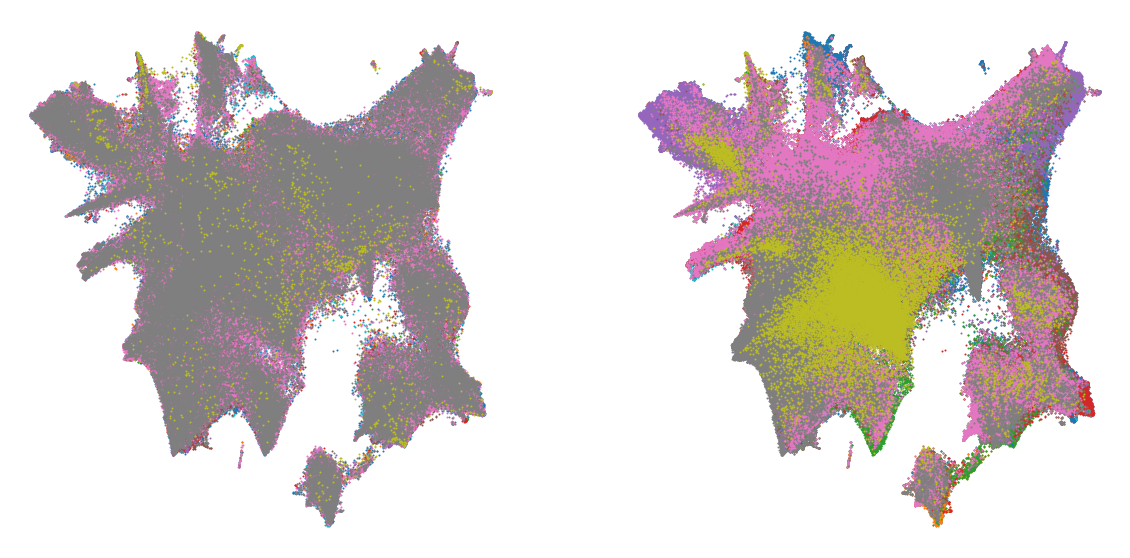

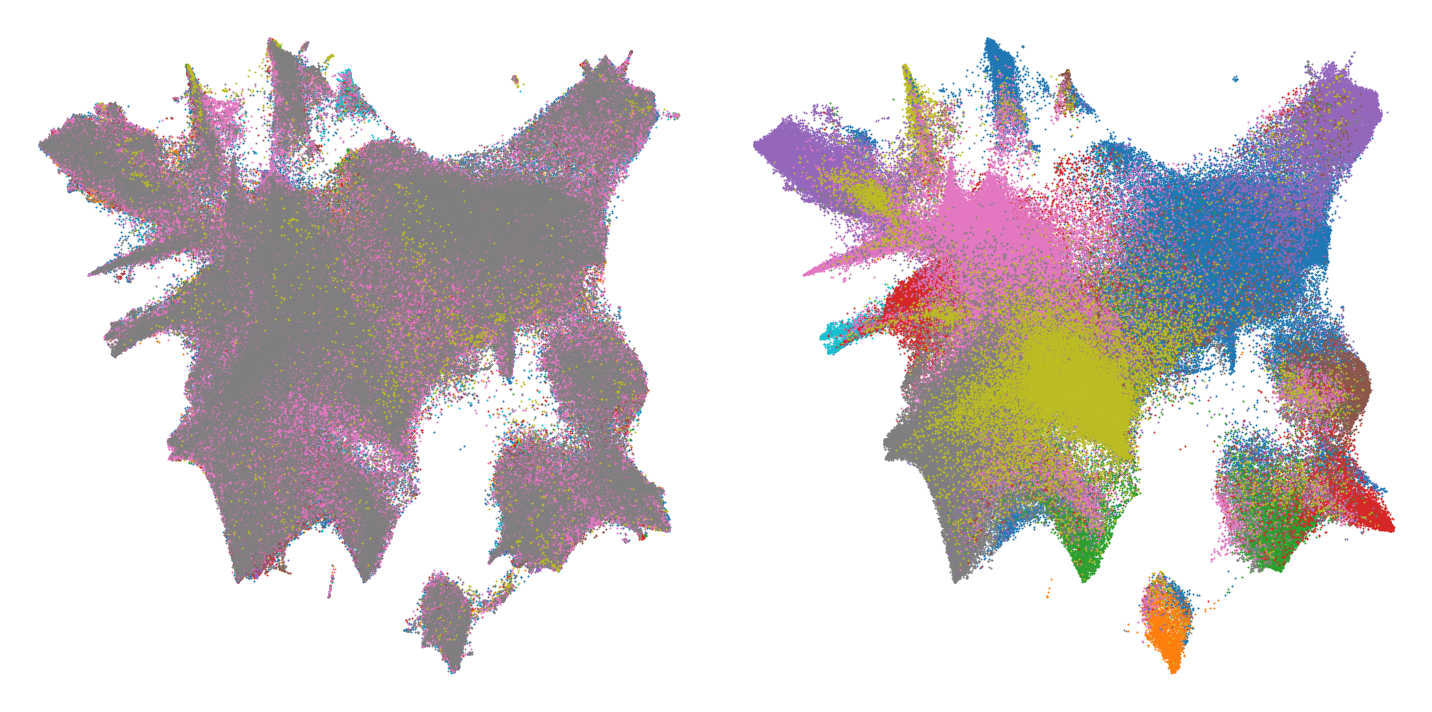

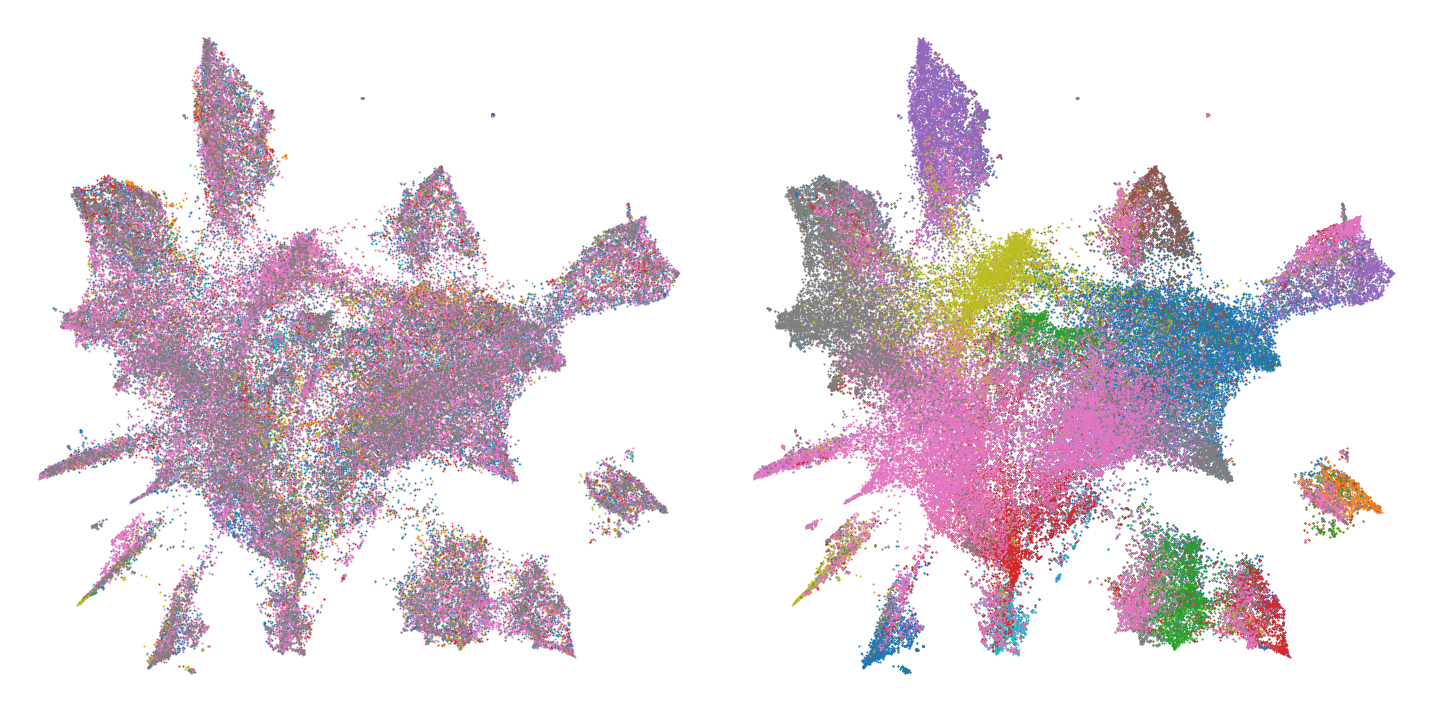

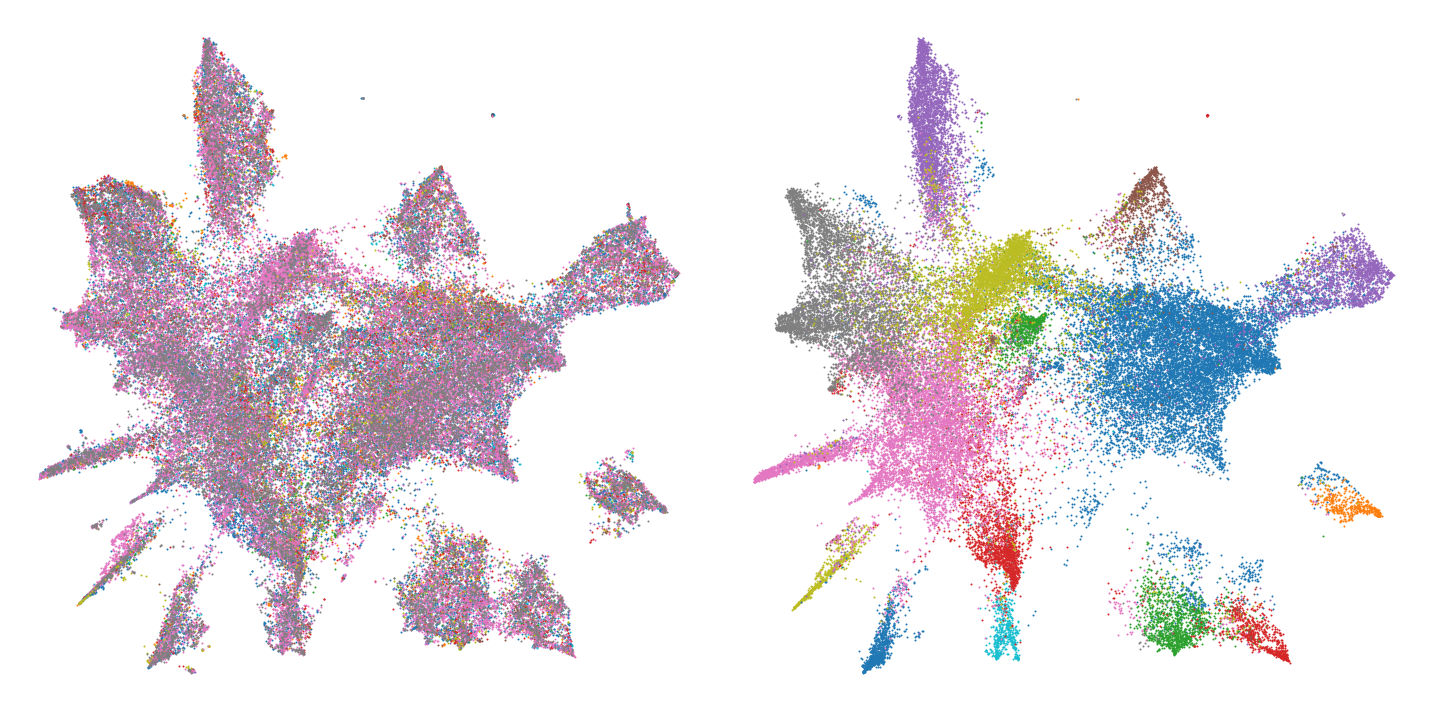

In [17]:
no_nan = np.where(np.isnan(features.mean(axis=1)) == False)[0]
features = features[no_nan]
image_IDs = np.array(image_IDs)[no_nan]

df_ID_groups = df.groupby('ID').groups
ID_groups = pd.DataFrame(image_IDs).groupby(0).groups
proteins = np.zeros((len(image_IDs), 19))
cell_lines = np.zeros((len(image_IDs))).astype(str)
for ID in tqdm(sorted(ID_groups.keys())):
    cell_lines[ID_groups[ID]] = df.iloc[df_ID_groups[ID]].cell_type.values[0]
    proteins[ID_groups[ID],:] = df.iloc[df_ID_groups[ID]][labels].values.astype(int)[0]
cell_lines = np.array(cell_lines)
proteins = np.stack(proteins)    

scaled_features = StandardScaler().fit_transform(features)
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_features)

i = image_IDs
c = np.array(cell_lines)
p = np.array(proteins)
f = features
unique_IDs = sorted(ID_groups.keys())
averaged_features = [f[ID_groups[ID]].mean(axis=0) for ID in unique_IDs]
averaged_protein = [p[ID_groups[ID][0]] for ID in unique_IDs]
averaged_cell_line = [(c)[ID_groups[ID][0]] for ID in unique_IDs]

averaged_features = np.stack(averaged_features)
averaged_protein = np.stack(averaged_protein)
averaged_cell_line = np.stack(averaged_cell_line)

averaged_scaled_features = StandardScaler().fit_transform(averaged_features)
reducer = umap.UMAP()
averaged_embedding = reducer.fit_transform(averaged_scaled_features)

fig, axes = plt.subplots(1,2,figsize=(20,10))
unique_cells = np.unique(c)
for u in unique_cells:
    indices = np.where(np.array(c) == u)[0]
    axes[0].scatter(embedding[indices,0],
               embedding[indices,1],
               s=1)    
    axes[0].axis('off')    
for i in range(19):
    indices = np.where(p[:,i])[0]
    axes[1].scatter(embedding[indices,0],
               embedding[indices,1],
               s=1)  
    axes[1].axis('off')

fig, axes = plt.subplots(1,2,figsize=(20,10))
unique_cells = np.unique(c)
for u in unique_cells:
    indices = np.where(np.array(c) == u)[0]
    axes[0].scatter(embedding[indices,0],
               embedding[indices,1],
               s=1)    
    axes[0].axis('off')    
for i in range(19):
    indices = np.where((p[:,i]).astype(bool) & (p.sum(axis=1) == 1))[0]
    axes[1].scatter(embedding[indices,0],
               embedding[indices,1],
               s=1)  
    axes[1].axis('off')

plt.tight_layout()
plt.savefig('/scr/mdoron/Dino4Cells/kaggle_comparison/HPA-singlecell-2nd-dual-head-pipeline/full.png')

fig, axes = plt.subplots(1,2,figsize=(20,10))
unique_cells = np.unique(c)
averaged_cell_line = np.array(averaged_cell_line)
averaged_protein = np.array(averaged_protein)
for u in unique_cells:
    indices = np.where(averaged_cell_line == u)[0]
    axes[0].scatter(averaged_embedding[indices,0],
               averaged_embedding[indices,1],
               s=1)    
    axes[0].axis('off')    
for i in range(19):
    indices = np.where(averaged_protein[:,i])[0]
    axes[1].scatter(averaged_embedding[indices,0],
               averaged_embedding[indices,1],
               s=1)  
    axes[1].axis('off')

plt.tight_layout()
plt.savefig('/scr/mdoron/Dino4Cells/kaggle_comparison/HPA-singlecell-2nd-dual-head-pipeline/average.png')

fig, axes = plt.subplots(1,2,figsize=(20,10))
unique_cells = np.unique(c)
averaged_cell_line = np.array(averaged_cell_line)
averaged_protein = np.array(averaged_protein)
for u in unique_cells:
    indices = np.where(averaged_cell_line == u)[0]
    axes[0].scatter(averaged_embedding[indices,0],
               averaged_embedding[indices,1],
               s=1)    
    axes[0].axis('off')    

for i in range(19):
    indices = np.where((averaged_protein[:,i]).astype(bool) & (averaged_protein.sum(axis=1) == 1))[0]
    axes[1].scatter(averaged_embedding[indices,0],
               averaged_embedding[indices,1],
               s=1)  
    axes[1].axis('off')

plt.tight_layout()
plt.savefig('/scr/mdoron/Dino4Cells/kaggle_comparison/HPA-singlecell-2nd-dual-head-pipeline/average.png')


In [ ]:
image_level = pd.concat(whole_dfs)
image_pred = image_level.reset_index().merge(
    tm[['image_id', 'fname']], left_on='index', right_on='image_id', how='left'
).set_index('fname').drop(['index', 'image_id'], 1)

In [ ]:
pub_pred = pd.concat(pdfs)
# merge_pred = pub_pred * image_pred.loc[pub_pred.index]
merge_pred = image_pred.loc[pub_pred.index]
df = pd.read_csv('/scr/mdoron/Dino4Cells/data/HPA_single_cell_data_fixed_masked_test.csv')
df = df.set_index('ID')
merge_pred.index.name = 'fname'
merge_pred = merge_pred.reset_index()
tm = tm.set_index('fname')

In [ ]:
merge_pred['ID'] = merge_pred['fname'].apply(lambda x:x.split('/')[-1].split('_')[0])
merge_pred['cell_ID'] = merge_pred['fname'].apply(lambda x:x.split('/')[-1].split('_')[-1].split('.')[0])


In [ ]:
j_pred = []
for iid in merge_pred.ID.unique():
    enc = ''
    sub_df = merge_pred[merge_pred.ID == iid]
    for idx, row in sub_df.iterrows():
        for i in range(19):
            enc += f'{i} {row[i]} {tm.loc[row.fname].enc} '
    j_pred.append({
        'ID': iid,
        'ImageWidth': widths[f'{iid}_{row.cell_ID}'],
        'ImageHeight': heights[f'{iid}_{row.cell_ID}'],
        'PredictionString': enc[:-1]
    })

In [ ]:
fast_sub = pd.DataFrame(j_pred)
fast_sub.to_csv('pub.csv')
fast_sub = fast_sub.set_index('ID')
submission = fast_sub.sort_values(by="ID")
submission.to_csv('/scr/mdoron/Dino4Cells/kaggle_comparison/HPA-singlecell-2nd-dual-head-pipeline/submission_no_tta_no_cell.csv')

In [ ]:
# fig, axes = plt.subplots(1,2,figsize=(20,10))
# unique_cells = np.unique(c)
# averaged_cell_line = np.array(averaged_cell_line)
# averaged_protein = np.array(averaged_protein)
# for u in unique_cells:
#     indices = np.where(averaged_cell_line == u)[0]
#     axes[0].scatter(averaged_embedding[indices,0],
#                averaged_embedding[indices,1],
#                s=1)    
#     axes[0].axis('off')    
# for i in range(19):
#     indices = np.where((averaged_protein[:,i] == 1))[0]
#     axes[1].scatter(averaged_embedding[indices,0],
#                averaged_embedding[indices,1],
#                s=1)  
#     axes[1].axis('off')


In [ ]:
labels = (list(protein_to_num_single_cells.keys()))
df_ID_groups = df.groupby('ID').groups
ID_groups = pd.DataFrame(image_IDs).groupby(0).groups
proteins = np.zeros((len(image_IDs), 19))
cell_lines = np.zeros((len(image_IDs))).astype(str)
for ID in tqdm(sorted(ID_groups.keys())):
    cell_lines[ID_groups[ID]] = df.iloc[df_ID_groups[ID]].cell_type.values[0]
    proteins[ID_groups[ID],:] = df.iloc[df_ID_groups[ID]][labels].values.astype(int)[0]
cell_lines = np.array(cell_lines)
proteins = np.stack(proteins)    
i = image_IDs
c = np.array(cell_lines)
p = np.array(proteins)
f = a[0]
f[np.unique(np.where(np.isnan(a[0]))[0]),:] = 0
torch.save((f,p,c,i), '/scr/mdoron/Dino4Cells/kaggle_comparison/HPA-singlecell-2nd-dual-head-pipeline/features.pth')

In [ ]:
f,p,c,i = torch.load('/scr/mdoron/Dino4Cells/kaggle_comparison/HPA-singlecell-2nd-dual-head-pipeline/features.pth')

In [ ]:
image_paths = df.file.apply(lambda x:x.split('/')[-1].split('.')[0]).values

In [ ]:
torch.save((torch.concat(features),image_IDs, image_paths), '/scr/mdoron/Dino4Cells/kaggle_comparison/HPA-singlecell-2nd-dual-head-pipeline/test_features.pth')